In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'zebra_finch_gardner_segmented'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=250,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 250,
    butter_highcut = 12000,
    ref_level_db = 20,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 12761 tasks      | elapsed:    8.8s


[Parallel(n_jobs=-1)]: Done 18028 out of 18028 | elapsed:    9.3s finished


In [9]:
dataset.sample_json

OrderedDict([('species', 'Taeniopygia guttata'),
             ('common_name', 'Zebra finch'),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/zebra_finch_gardner/2019-10-08_10-16-03/WAV/lr12_2551.WAV'),
             ('noise_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/zebra_finch_gardner/2019-10-08_10-16-03/NOISE/lr12_2551.WAV'),
             ('samplerate_hz', 48000),
             ('length_s', 0.44295833333333334),
             ('wav_num', 2551),
             ('indvs',
              OrderedDict([('lr12',
                            OrderedDict([('motifs',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [0.44295833333333334])])),
                                         ('syllables',
                                          OrderedD

In [10]:
len(dataset.data_files)

18028

#### Create dataset based upon JSON

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1882s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1229s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed:    1.8s
[Parallel(n_j

[Parallel(n_jobs=-1)]: Done 17981 out of 18028 | elapsed:   27.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 18028 out of 18028 | elapsed:   27.0s finished


65893

In [13]:
syllable_df[:3]

start_time  end_time  indv  indvi        key
0       0.000     0.143  lr12      0  lr12_2551
1       0.149     0.227  lr12      0  lr12_2551
2       0.239     0.343  lr12      0  lr12_2551

### get audio for dataset

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0559s.) Setting batch_size=42.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (5.2102s.) Setting batch_size=21.
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (3.3287s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1349 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1479 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 1629 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Don

[Parallel(n_jobs=-1)]: Done 18028 out of 18028 | elapsed:  2.6min finished


65893

In [ ]:
syllable_df[:3]

start_time  end_time  indv  indvi        key  \
0       0.000     0.143  lr12      0  lr12_2551   
1       0.149     0.227  lr12      0  lr12_2551   
2       0.239     0.343  lr12      0  lr12_2551   

                                               audio   rate  
0  [-0.005017217410633742, -0.030003277431562933,...  48000  
1  [-0.017890375310140837, -0.017437939973938076,...  48000  
2  [0.013705346311330276, 0.013260862628047545, 0...  48000

In [ ]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
sylls = syllable_df.audio.values

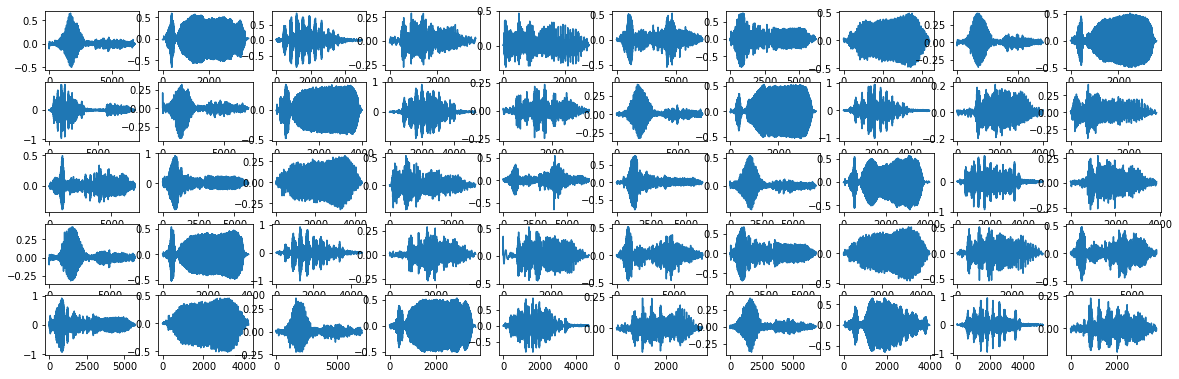

In [ ]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [ ]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [ ]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [ ]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0595s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1554s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1414 tasks      | elapsed:    0.9s
[Parallel(

[Parallel(n_jobs=-1)]: Done 65893 out of 65893 | elapsed:   25.7s finished


### Rescale spectrogram
- using log rescaling

In [ ]:
log_scaling_factor = 4

In [ ]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0039s.) Setting batch_size=102.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0562s.) Setting batch_size=726.
[Parallel(n_jobs=-1)]: Done 1182 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4812 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 9894 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 14976 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 21510 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 28044 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 36030 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 44016 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 53454 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 62892 tasks      | elapsed:    8.3s


[Parallel(n_jobs=-1)]: Done 65893 out of 65893 | elapsed:    8.6s finished


(25.0, 10) (320, 800) 25.0 32 800


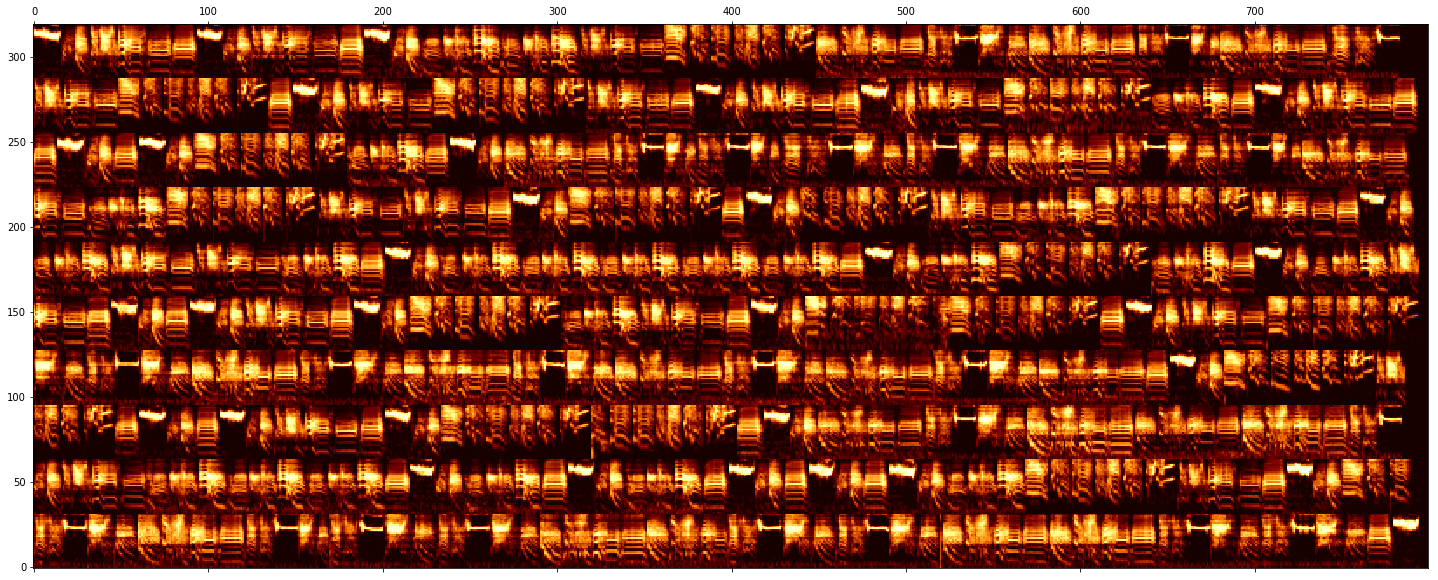

In [ ]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [ ]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [ ]:
syllable_df[:3]

start_time  end_time  indv  indvi        key  \
0       0.000     0.143  lr12      0  lr12_2551   
1       0.149     0.227  lr12      0  lr12_2551   
2       0.239     0.343  lr12      0  lr12_2551   

                                               audio   rate  
0  [-0.005017217410633742, -0.030003277431562933,...  48000  
1  [-0.017890375310140837, -0.017437939973938076,...  48000  
2  [0.013705346311330276, 0.013260862628047545, 0...  48000

In [ ]:
import seaborn as sns

In [ ]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0701s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0373s.) Setting batch_size=42.
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1595s.) Setting batch_size=104.
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1718 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3012 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4988 tasks      | el

[Parallel(n_jobs=-1)]: Done 65893 out of 65893 | elapsed:    8.2s finished


(25.0, 10) (320, 800) 25.0 32 800


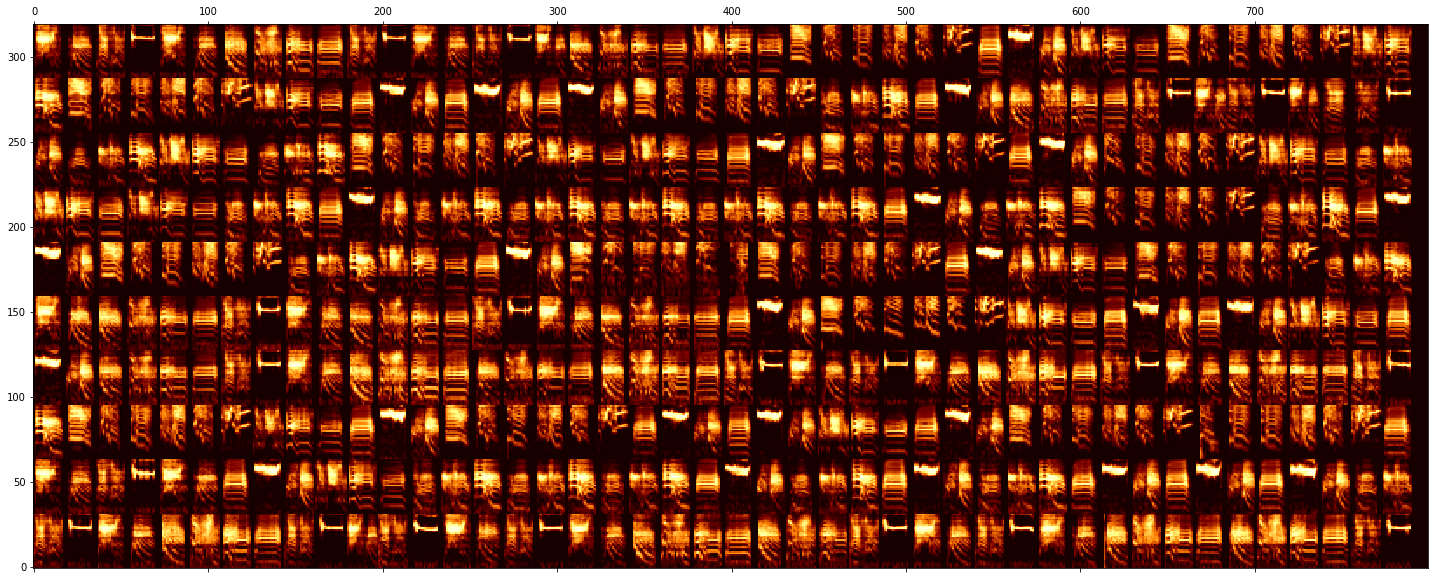

In [ ]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [ ]:
np.shape(syllables_spec)

(65893, 32, 18)

In [ ]:
syllable_df['spectrogram'] = syllables_spec

In [ ]:
syllable_df[:3]

start_time  end_time  indv  indvi        key  \
0       0.000     0.143  lr12      0  lr12_2551   
1       0.149     0.227  lr12      0  lr12_2551   
2       0.239     0.343  lr12      0  lr12_2551   

                                               audio   rate  \
0  [-0.005017217410633742, -0.030003277431562933,...  48000   
1  [-0.017890375310140837, -0.017437939973938076,...  48000   
2  [0.013705346311330276, 0.013260862628047545, 0...  48000   

                                         spectrogram  
0  [[0.11670862, 0.06737542, 0.084003605, 0.12961...  
1  [[0.0, 0.0, 0.06625868, 0.10274482, 0.05996425...  
2  [[0.0, 0.27093738, 0.040522195, 0.114609785, 0...

### view syllables per indv

lny42 12959
(50.0, 32) (512, 800) 25.0 32 800


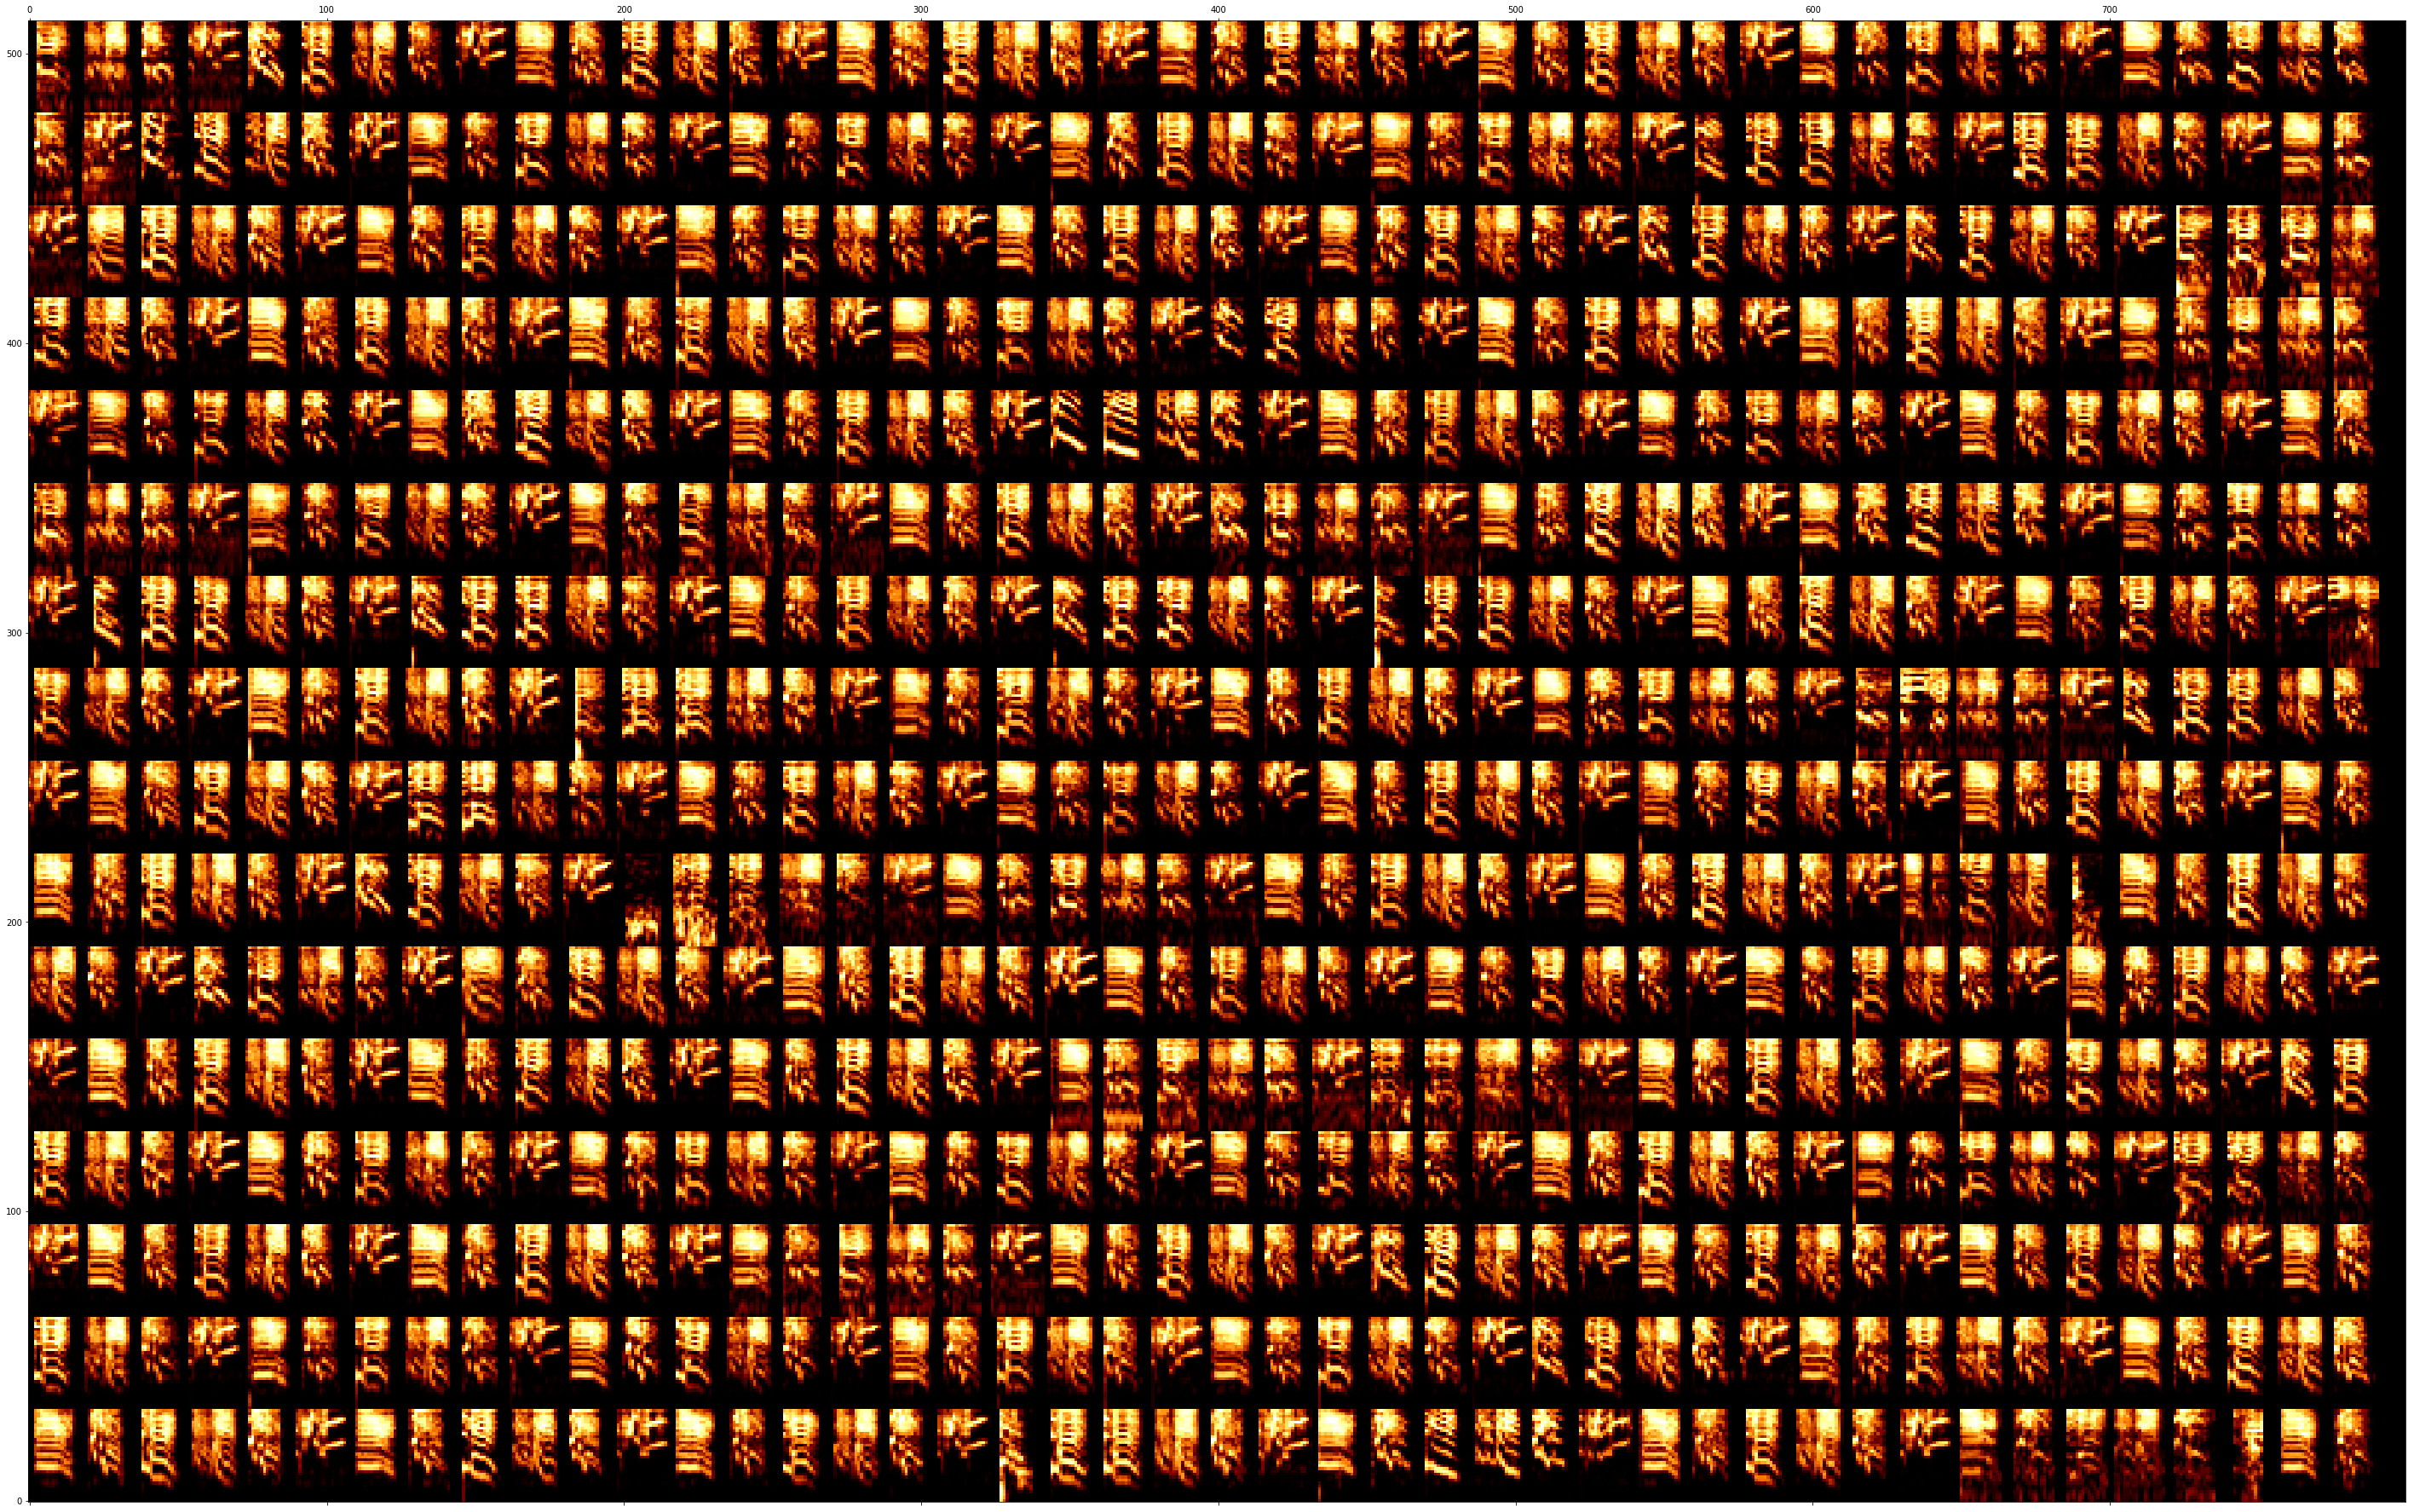

lny64 8449
(50.0, 32) (512, 800) 25.0 32 800


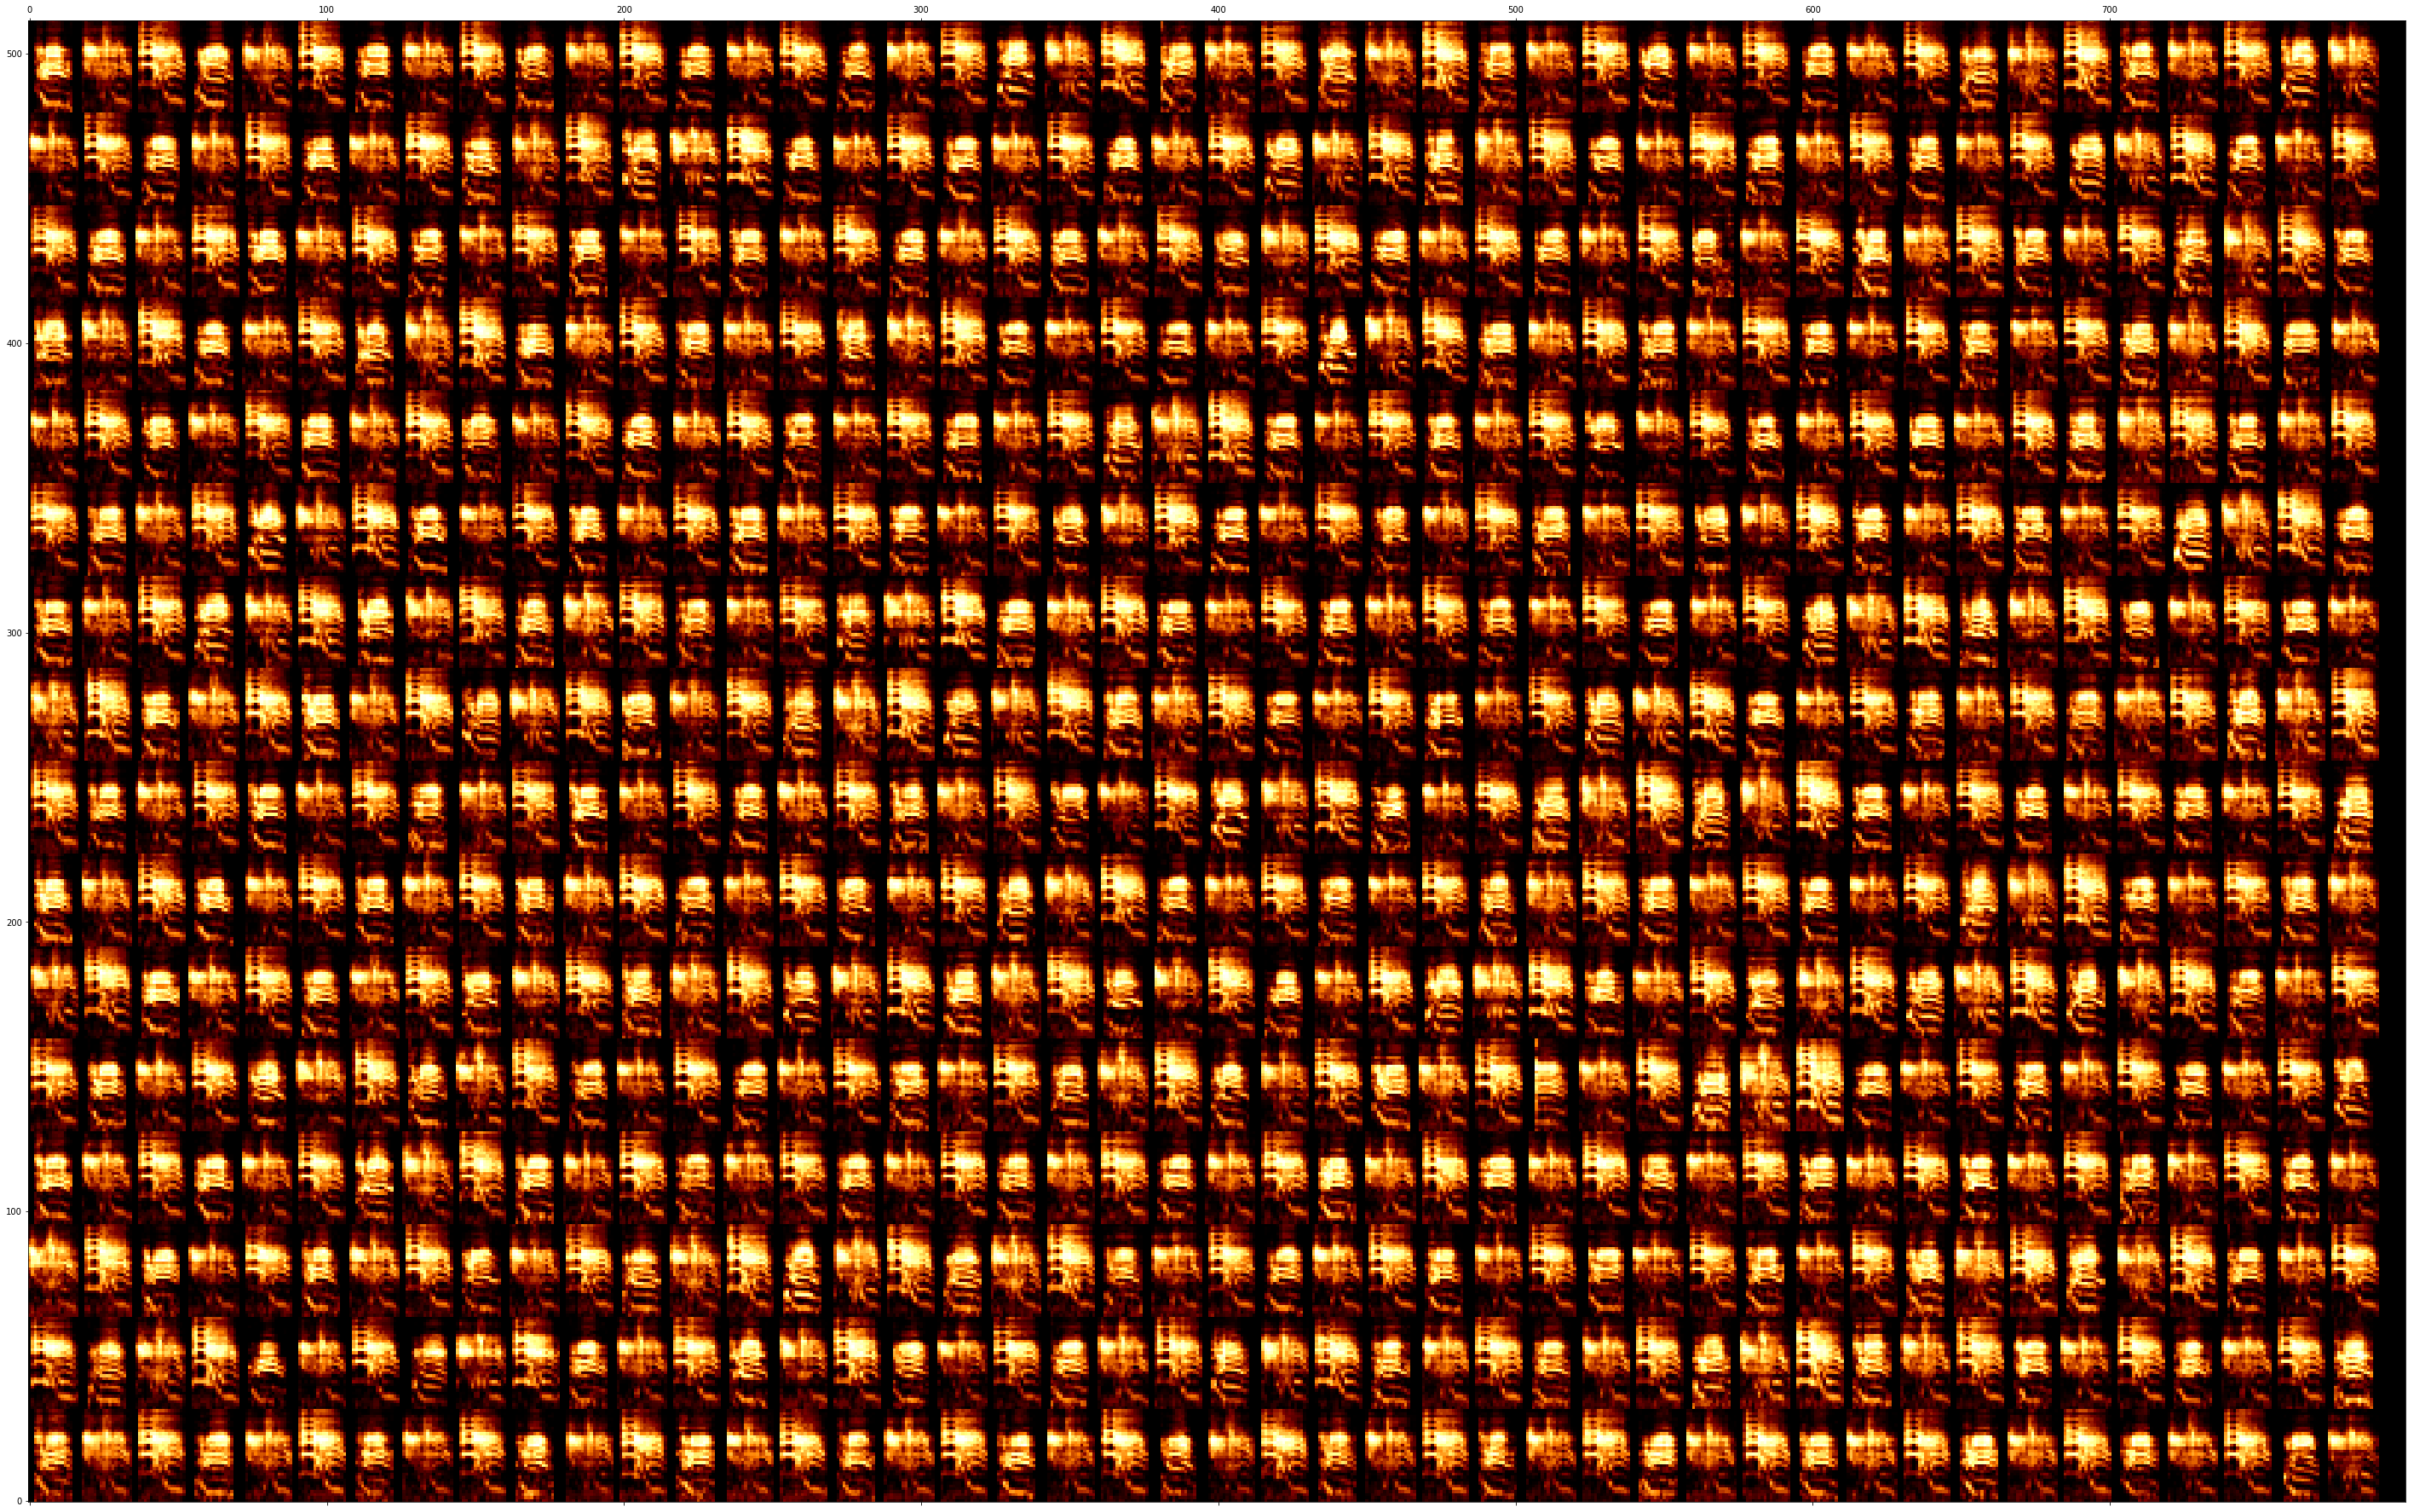

lr12 11369
(50.0, 32) (512, 800) 25.0 32 800


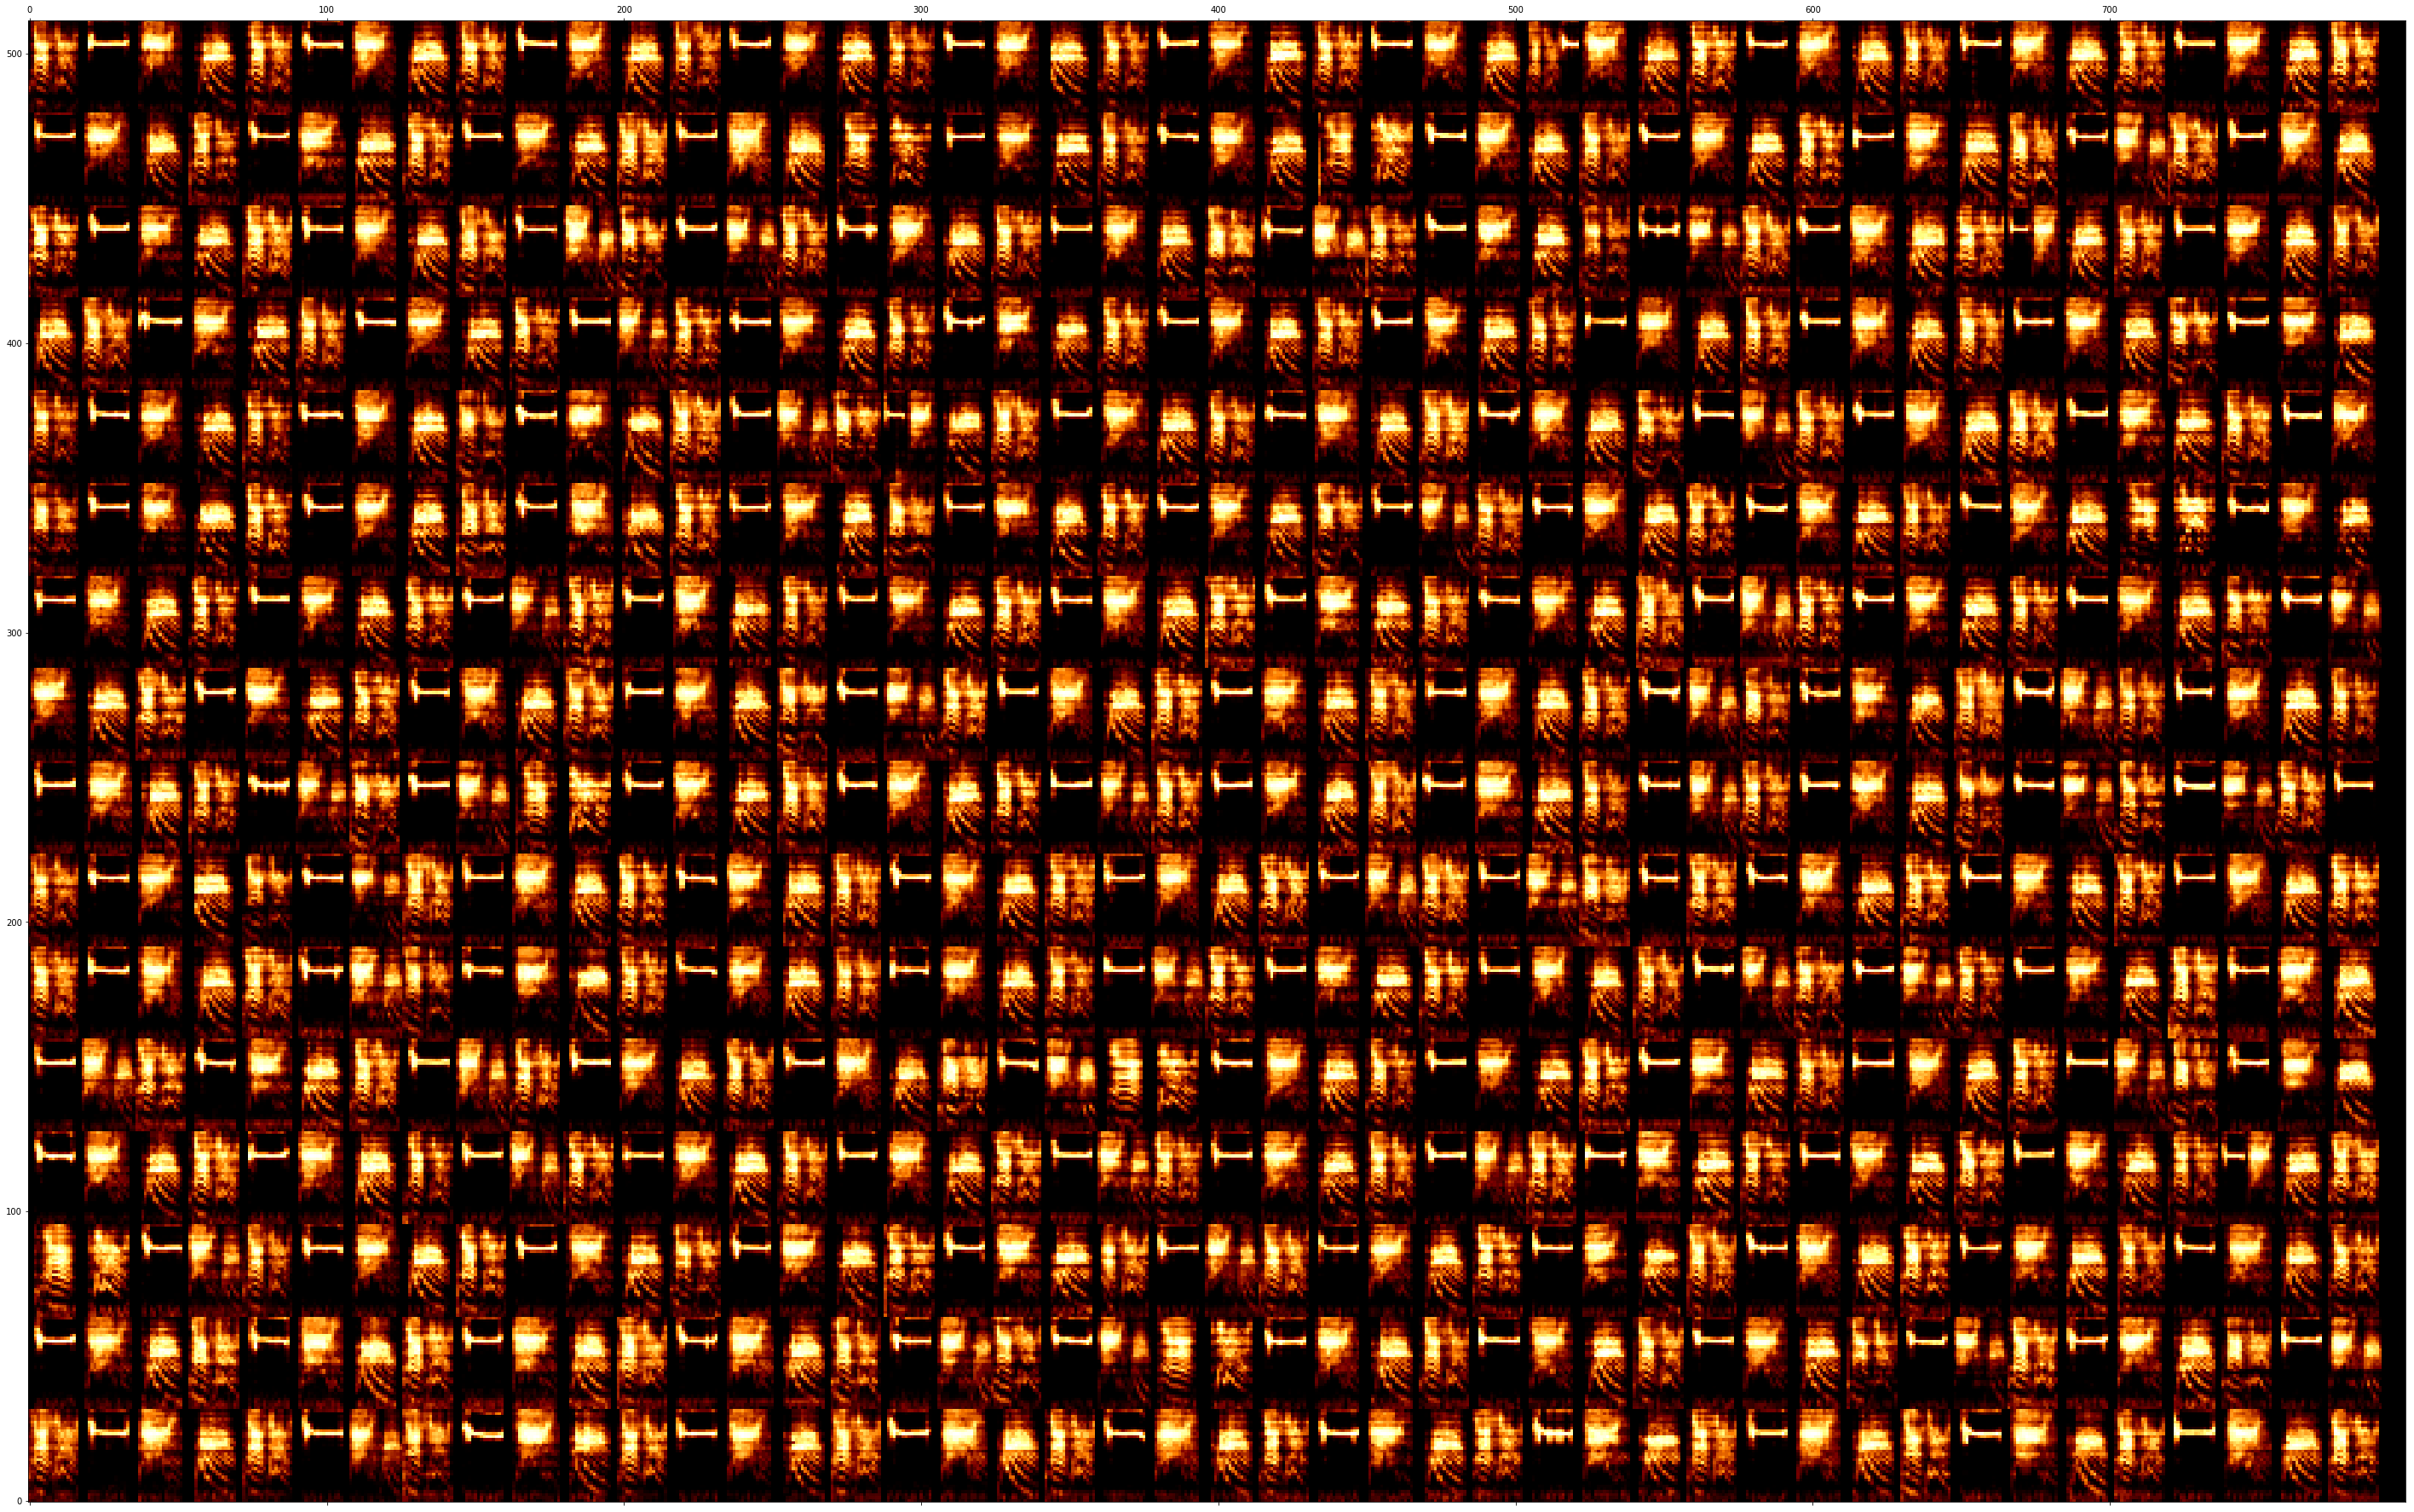

lr13 9118
(50.0, 32) (512, 800) 25.0 32 800


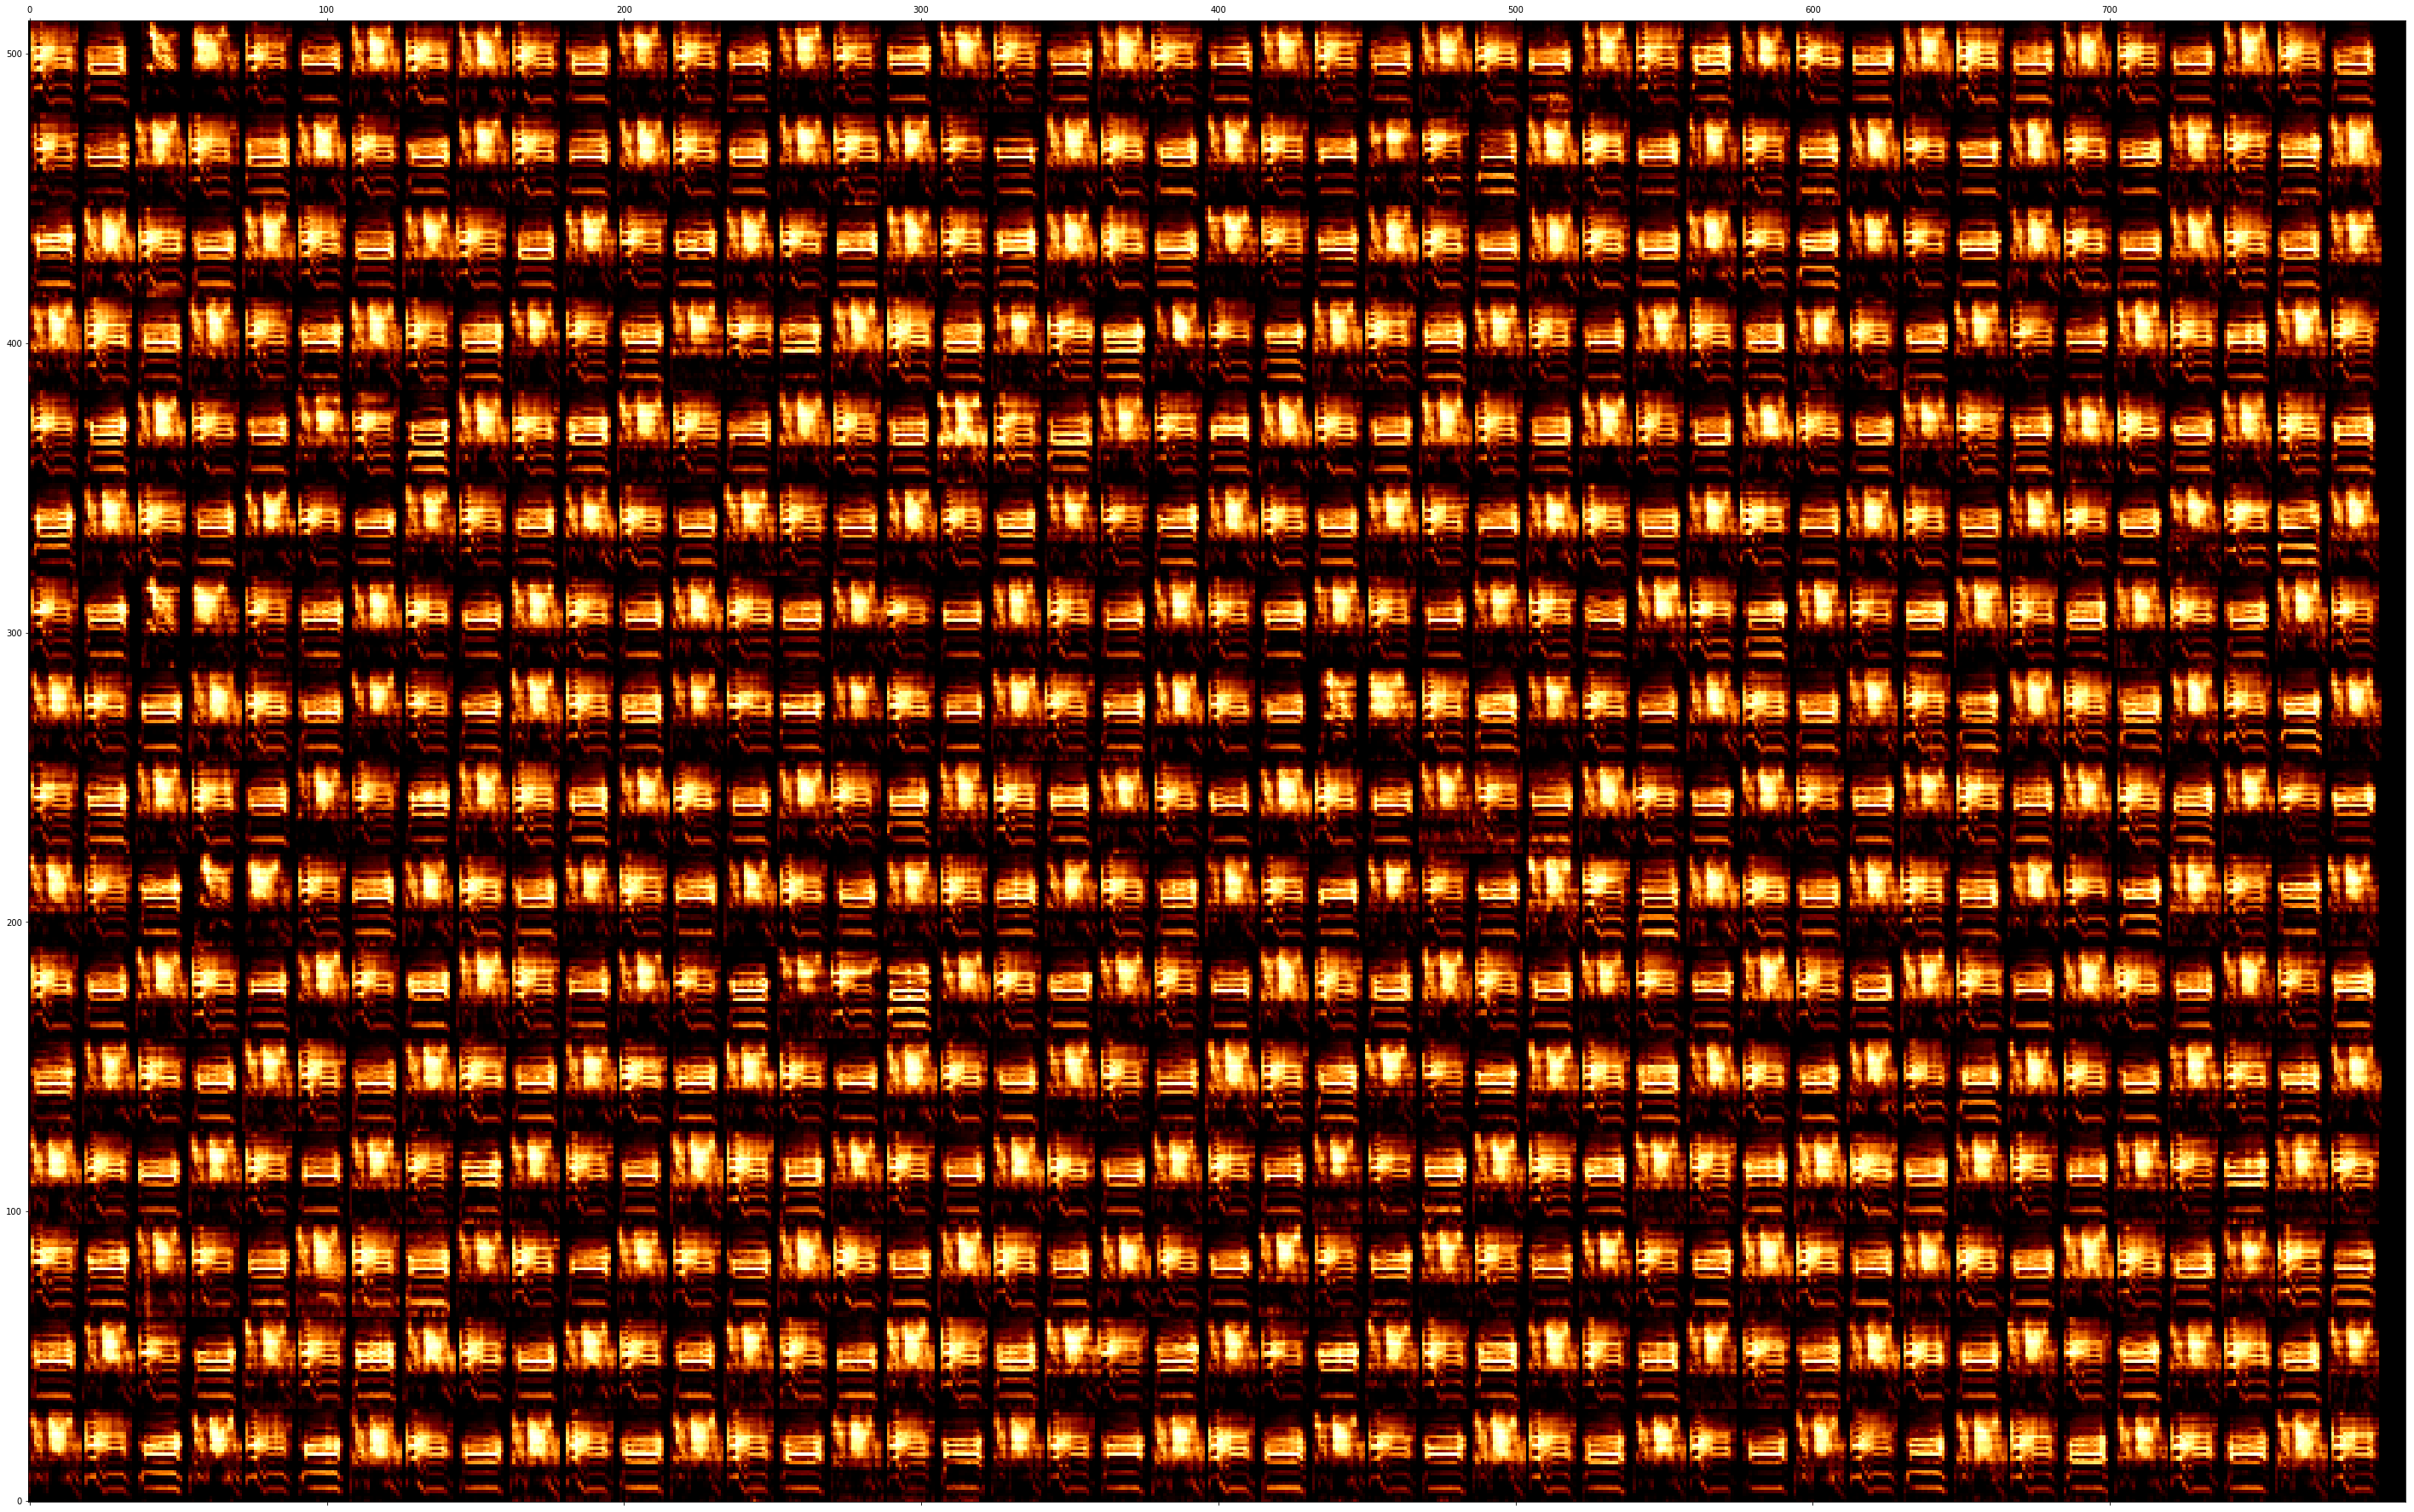

lr28 12067
(50.0, 32) (512, 800) 25.0 32 800


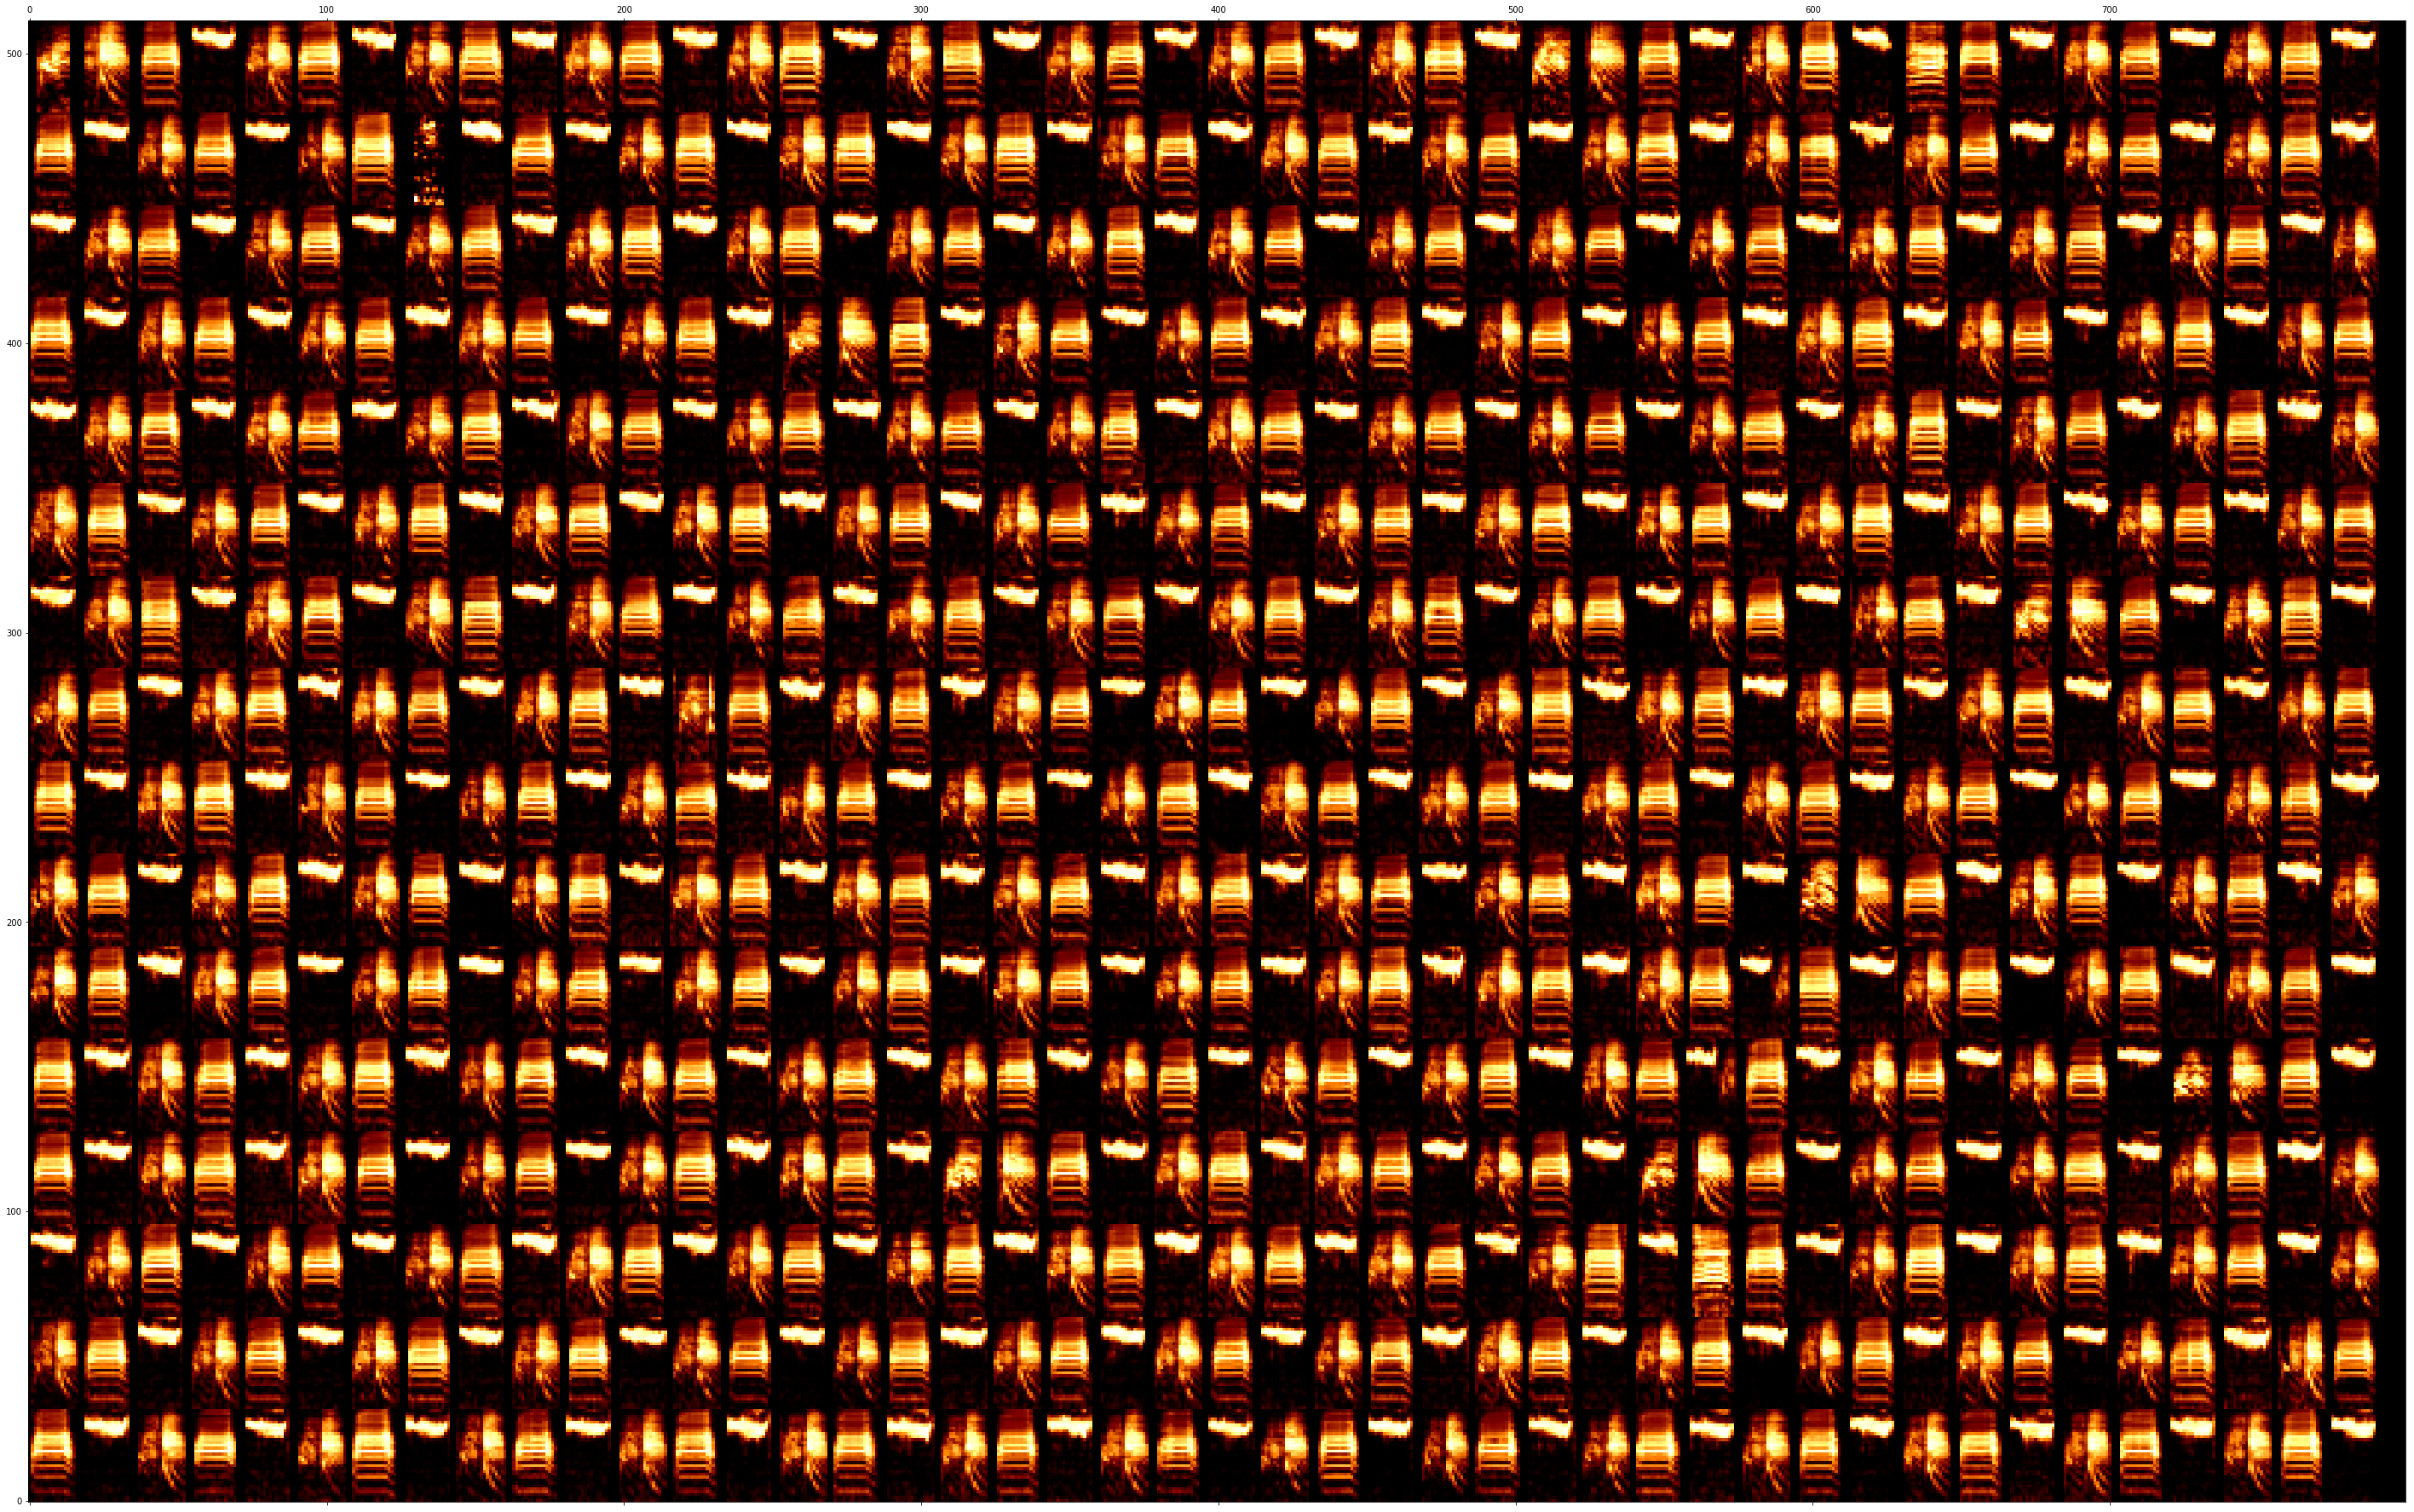

lr77 11931
(50.0, 32) (512, 800) 25.0 32 800


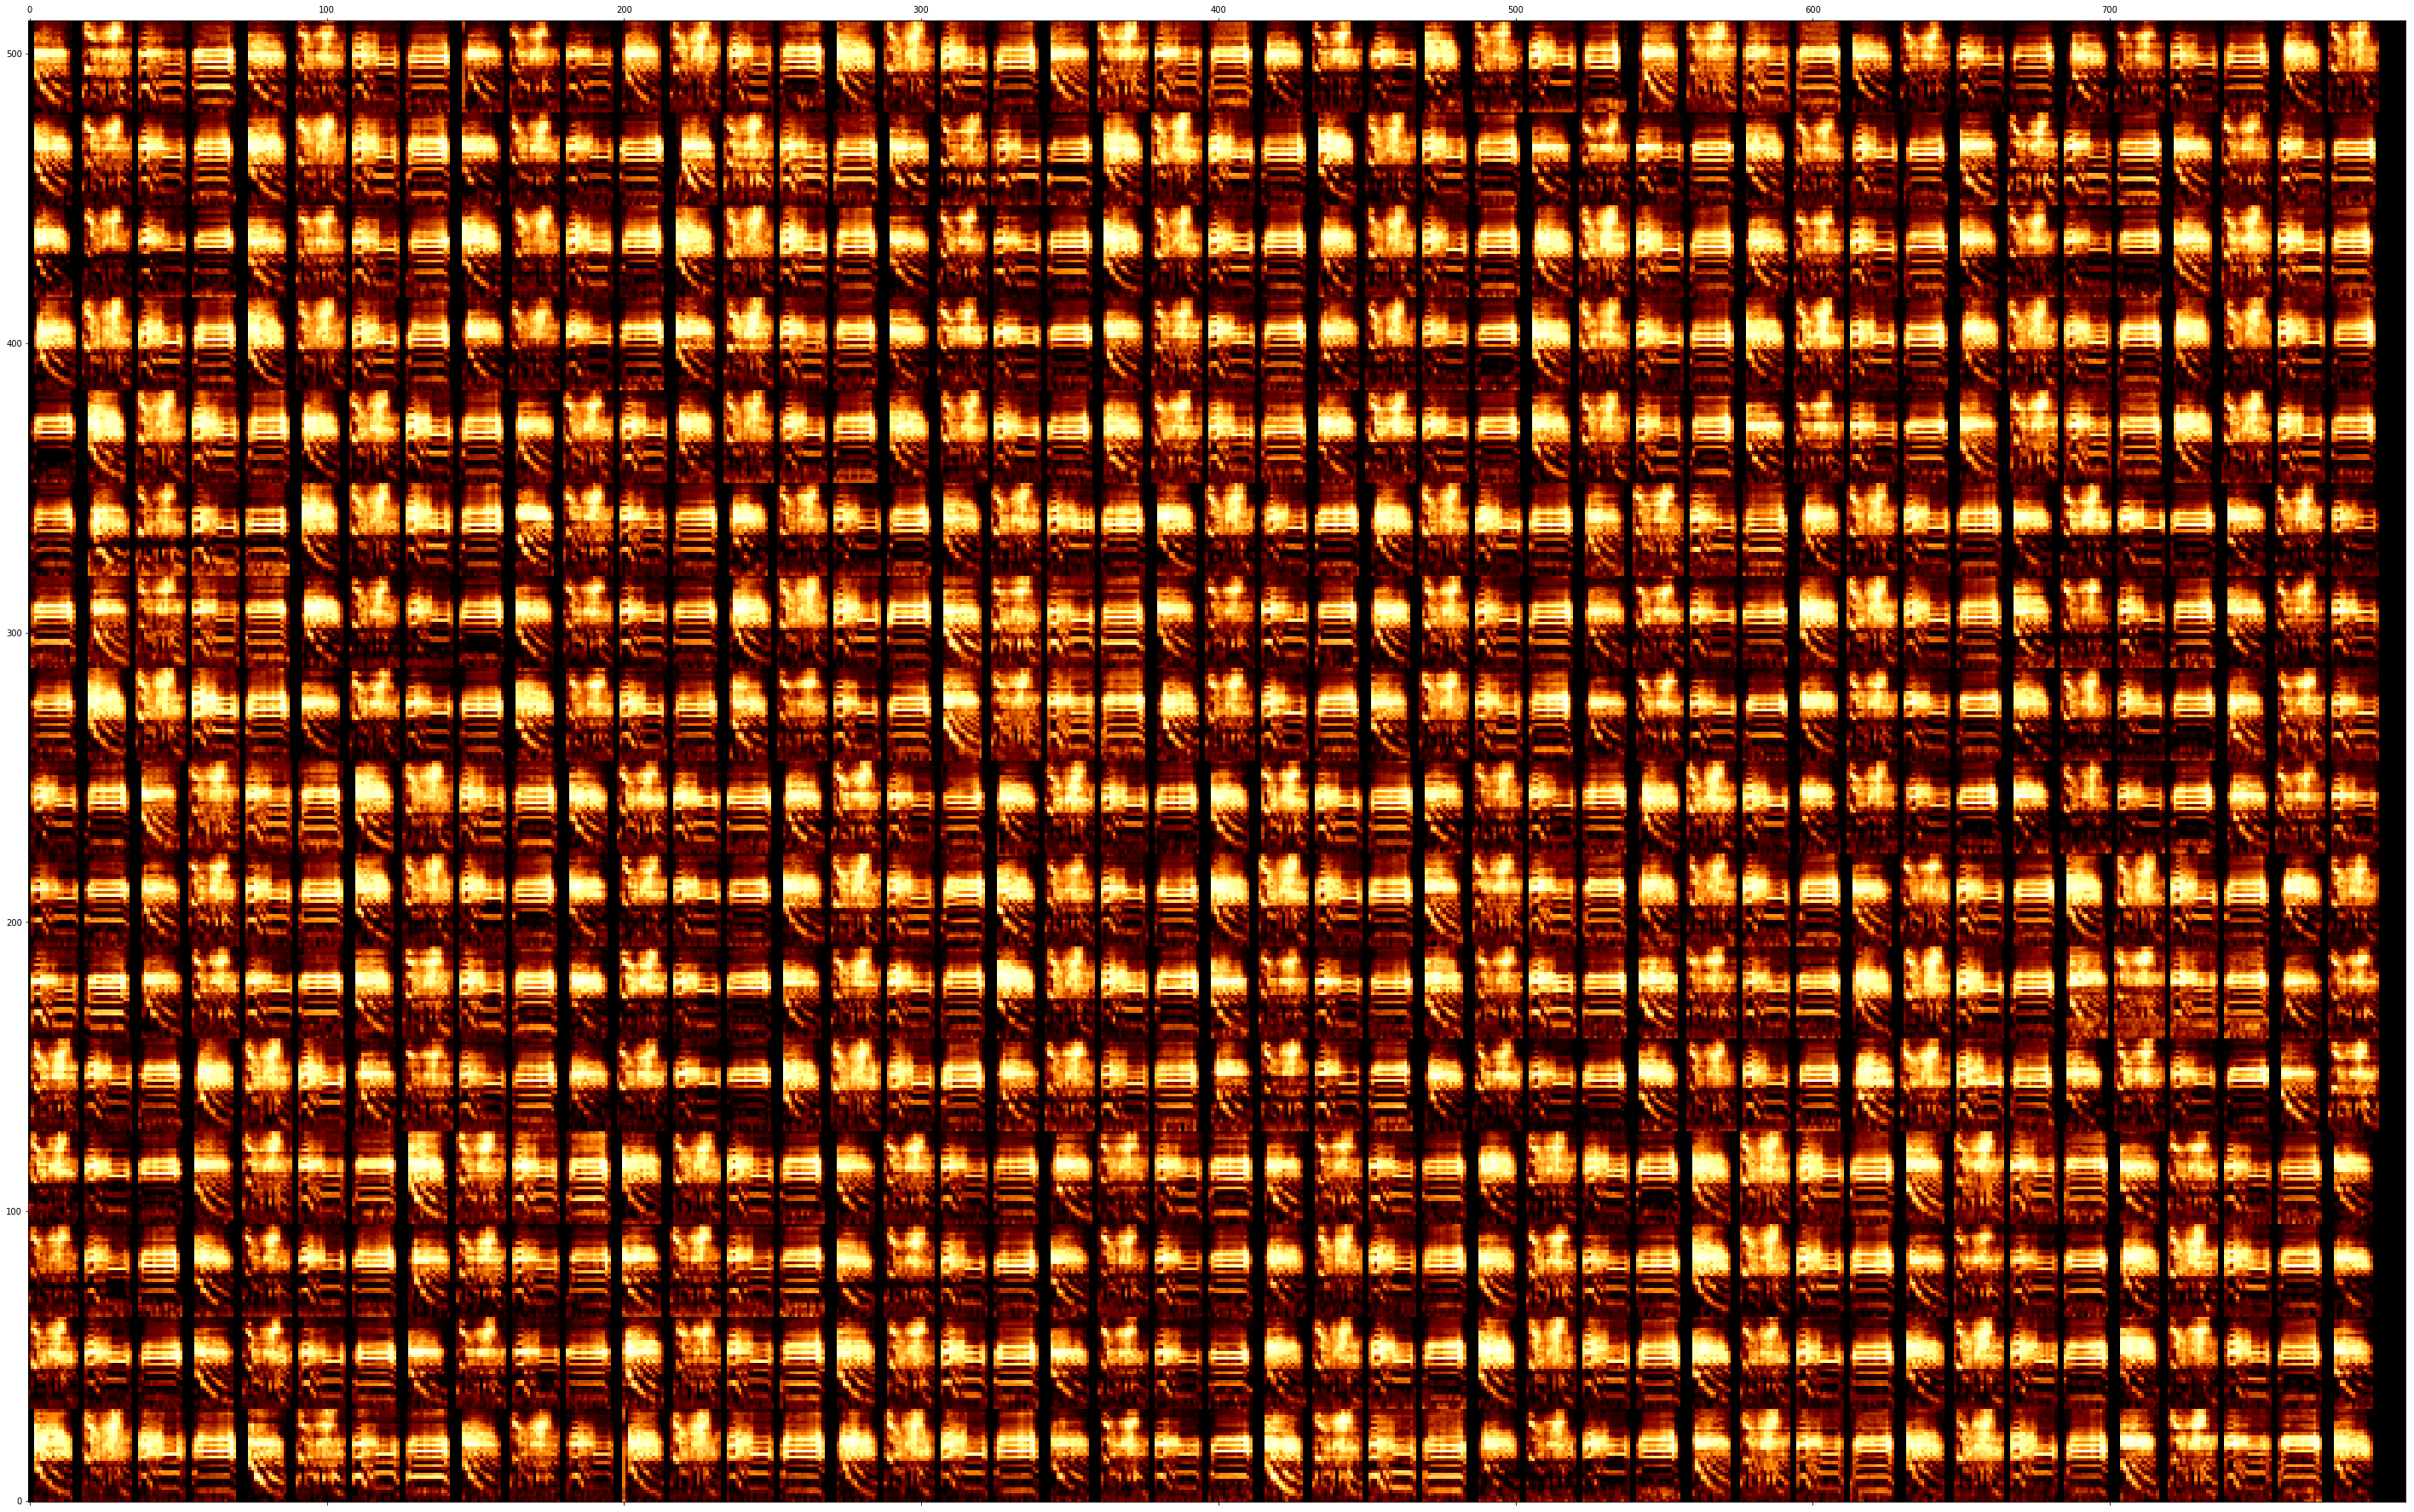

In [ ]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [ ]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'zf.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)